# Lab 3 - Comparing Classification Models



---















In this session, we demonstrate how to solve a text classification task using simple 
feedforward neural network classifier. We will use IMDB Large Movie Review Dataset to train a binary classification model, able to predict whether a review is positive or negative. First, our network takes one-hot word vectors as input, averages them to make one vector and trains a 
fully-connected layer to predict the output. In the second part, we replace the one-hot vectors with the word embeddings and add a layer to see how much that improves the performance.

We are going to use Keras Sequential API in this session. The Sequential API allows you to make models layer-by-layer. But it is not straightforward to define models where layers connect to more than just the previous and next layers. 

In [ ]:
!pip install tensorflow

In [ ]:
import tensorflow.keras as tk
import numpy as np
from keras.layers import Lambda, GlobalAveragePooling1D, Dense, Embedding
from keras import backend as K
from keras.models import Sequential
import matplotlib.pyplot as plt


### Downloading data

The dataset we will be using is the IMDB Large Movie Review Dataset, which consists of 50000 labeled movie reviews. These are split into 25,000 reviews for training and 25,000 reviews for testing. The  dataset contains an even number of positive and negative reviews, so randomly guessing yields 50% accuracy. The data is preprocessed. For text classification, it is ususal to limit the size of the vocabulary to stop the dataset from becoming too sparse, creating possible overfitting. We keep the top 10,000 most frequently occurring words in the training data.


In [ ]:
imdb = tk.datasets.imdb
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=10000,seed=113)

We now can start playing around with the data, let’s first see the length:

In [ ]:
print("Training entries: {}, labels: {}".format(len(X_train), len(y_train)))

Training entries: 25000, labels: 25000


The  reviews have been converted to integers and each integer represents a  word in a dictionary. 

In [ ]:
X_train[0][:10]

[1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65]

We can convert integers back to words by querying a dictionary object that contains the integer to string mapping:

In [ ]:
word_index = imdb.get_word_index()

Index 1 represents the beginning of the sentence and the index 2 is assigned to all unknown tokens. Index 0 will be used for padding.

In [ ]:
word_index

In [ ]:
word_index = {k:(v+3) for k,v in word_index.items()}
word_index["<PAD>"] = 0
word_index["<START>"] = 1
word_index["<UNK>"] = 2  
word_index["<UNUSED>"] = 3

In [ ]:
word_index

To reverse key and values in a dictionary:

In [ ]:
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

To view a word:

In [ ]:
reverse_word_index[25]

'you'

And to recreate the whole sentence from our training data we define decode_review:


In [ ]:
def decode_review(text):
    return ' '.join([reverse_word_index.get(i, '?') for i in text])

In [ ]:
decode_review(X_train[10])

"<START> french horror cinema has seen something of a revival over the last couple of years with great films such as inside and <UNK> romance <UNK> on to the scene <UNK> <UNK> the revival just slightly but stands head and shoulders over most modern horror titles and is surely one of the best french horror films ever made <UNK> was obviously shot on a low budget but this is made up for in far more ways than one by the originality of the film and this in turn is <UNK> by the excellent writing and acting that ensure the film is a winner the plot focuses on two main ideas prison and black magic the central character is a man named <UNK> sent to prison for fraud he is put in a cell with three others the quietly insane <UNK> body building <UNK> marcus and his retarded boyfriend daisy after a short while in the cell together they stumble upon a hiding place in the wall that contains an old <UNK> after <UNK> part of it they soon realise its magical powers and realise they may be able to use it

### Creating One-hot word vectors

It is  common to use one-hot representation as input in Natural Language Processing tasks. In Keras, the Embedding layer takes an index as an input and convert it to one-hot vector with the length of the vocabulary size. Then multiplies these vectors by a normal weight matrix. But there is no way to only get a one-hot vector as the output of a layer in Keras. To solve this we use Lambda() layer and a function that creates the one-hot layer. 

In [ ]:
def OneHot(input_dim=None, input_length=None):
    
    if input_dim is None or input_length is None:
        raise TypeError("input_dim or input_length is not set")

    
    def _one_hot(x, num_classes):
        return K.one_hot(K.cast(x, 'uint8'),
                          num_classes=num_classes)

    return Lambda(_one_hot,
                  arguments={'num_classes': input_dim},
                  input_shape=(input_length,))

input_dim refers to the length of the one-hot vector and input_length refers to the length of the input sequence. Since the input to K.one_hot should be an integer tensor, we cast x to one (Keras passes around float tensors by default).



 Each text sequence has in most cases different length of words. Here, we fill sequences with a pad token (0) to fit the size. This special tokens is then masked not to be accounted in averaging, loss calculation etc. We set the maximum length to 256.

### Preparing input data

In [ ]:
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 256

X_train_enc = tk.preprocessing.sequence.pad_sequences(X_train,
                                                        value=word_index["<PAD>"],
                                                        padding='post',
                                                        maxlen=256)

X_test_enc = tk.preprocessing.sequence.pad_sequences(X_test,
                                                       value=word_index["<PAD>"],
                                                       padding='post',
                                                       maxlen=256)

And to view a padded review:

In [ ]:
print(X_train_enc[1])
print('\nLength: ',len(X_train_enc))

[   1  194 1153  194 8255   78  228    5    6 1463 4369 5012  134   26
    4  715    8  118 1634   14  394   20   13  119  954  189  102    5
  207  110 3103   21   14   69  188    8   30   23    7    4  249  126
   93    4  114    9 2300 1523    5  647    4  116    9   35 8163    4
  229    9  340 1322    4  118    9    4  130 4901   19    4 1002    5
   89   29  952   46   37    4  455    9   45   43   38 1543 1905  398
    4 1649   26 6853    5  163   11 3215    2    4 1153    9  194  775
    7 8255    2  349 2637  148  605    2 8003   15  123  125   68    2
 6853   15  349  165 4362   98    5    4  228    9   43    2 1157   15
  299  120    5  120  174   11  220  175  136   50    9 4373  228 8255
    5    2  656  245 2350    5    4 9837  131  152  491   18    2   32
 7464 1212   14    9    6  371   78   22  625   64 1382    9    8  168
  145   23    4 1690   15   16    4 1355    5   28    6   52  154  462
   33   89   78  285   16  145   95    0    0    0    0    0    0    0
    0 

Now we want to build the neural network model. We  are going to have a hidden layer with 16 hidden units. 

First, we want to transform each index to an embedded vector and then average all vectors to a single one. It has been showed that unweighted average of word vectors outperforms many complicated networks that model semantic and syntactic compositionality. As an example you can take a look at this: (http://anthology.aclweb.org/P/P15/P15-1162.pdf)

To average we need to ignore padded zeros:

In [ ]:
class GlobalAveragePooling1DMasked(GlobalAveragePooling1D):
    def call(self, x, mask=None):
        if mask != None:
            return K.sum(x, axis=1) / K.sum(mask, axis=1)
        else:
            return super().call(x)


# Model 1: Neural averaging network using one-hot vectors

The first layer is an one-hot layer. The second layer is to compute average on all word vectors in a sentence without considering padding. The  output vector is piped through a fully-connected layer. The last layer is connected with a single output node with the sigmoid activation function. The final value is a float between 0 and 1. 
The vocabulary count of the movie reviews (10000) is used as the input shape. At the end we visualize the model summary.

In [ ]:
from keras.layers import Input, Embedding, Dense, LSTM,Reshape
target_word = Input((256,), dtype='int32')

In [ ]:
X_train_enc.shape

(25000, 256)

In [ ]:
len(X_train_enc)

25000

In [ ]:
import tensorflow as tf
from keras.models import Model
model_one_hot=OneHot(VOCAB_SIZE,MAX_SEQUENCE_LENGTH)(target_word)
model_second=GlobalAveragePooling1DMasked()(model_one_hot)
output_layer = Dense(16,activation = 'sigmoid')(model_second)
output_layer_1 = Dense(1,activation = 'sigmoid')(output_layer)
model = Model(inputs=[target_word], outputs=output_layer_1)
model.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 lambda (Lambda)             (None, 256, 10000)        0         
                                                                 
 global_average_pooling1d_ma  (None, 10000)            0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable

In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256)]             0         
                                                                 
 lambda (Lambda)             (None, 256, 10000)        0         
                                                                 
 global_average_pooling1d_ma  (None, 10000)            0         
 sked (GlobalAveragePooling1                                     
 DMasked)                                                        
                                                                 
 dense (Dense)               (None, 16)                160016    
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 160,033
Trainable params: 160,033
Non-trainable

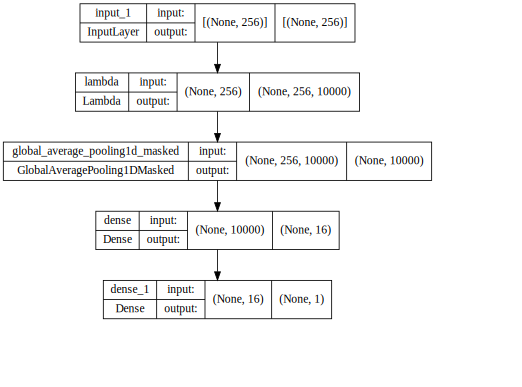

In [ ]:
from IPython.display import SVG
from keras.utils import vis_utils
SVG(vis_utils.model_to_dot(model, show_shapes=True, show_layer_names=True, dpi=60).create(prog='dot', format='svg'))  

### Training the model

To compile the model we need a loss function and an optimizer. We use binary_crossentropy loss function which is just a special case of categorical cross entropy. We also use Adam optimizer that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data. You can read more about it here:
(https://arxiv.org/abs/1412.6980v8
)


When training, we want to check the accuracy of the model on data it hasn't seen before. So we create a validation set:

In [ ]:
X_val = np.array(X_train_enc[:10000])
partial_X_train = np.array(X_train_enc[10000:])

y_val = np.array(y_train[:10000])
partial_y_train = np.array(y_train[10000:])

Then we start to train the model for 40 epochs in mini-batches of 512 samples and monitor the model's loss and accuracy on the validation set.

In [ ]:
print(partial_X_train.shape)
print(partial_y_train.shape)

(15000, 256)
(15000,)


In [ ]:
print(X_val.shape)
print(y_val.shape)

(10000, 256)
(10000,)


In [ ]:
history = model.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 4s 105ms/step - loss: 0.7559 - accuracy: 0.5035 - val_loss: 0.7343 - val_accuracy: 0.4947
Epoch 2/40
30/30 [==============================] - 3s 99ms/step - loss: 0.7149 - accuracy: 0.5035 - val_loss: 0.7057 - val_accuracy: 0.4947
Epoch 3/40
30/30 [==============================] - 3s 99ms/step - loss: 0.6981 - accuracy: 0.5035 - val_loss: 0.6958 - val_accuracy: 0.4947
Epoch 4/40
30/30 [==============================] - 3s 100ms/step - loss: 0.6935 - accuracy: 0.5035 - val_loss: 0.6932 - val_accuracy: 0.4947
Epoch 5/40
30/30 [==============================] - 3s 99ms/step - loss: 0.6925 - accuracy: 0.5035 - val_loss: 0.6925 - val_accuracy: 0.4947
Epoch 6/40
30/30 [==============================] - 3s 99ms/step - loss: 0.6921 - accuracy: 0.5035 - val_loss: 0.6921 - val_accuracy: 0.4947
Epoch 7/40
30/30 [==============================] - 3s 100ms/step - loss: 0.6917 - accuracy: 0.5061 - val_loss: 0.6917 - val_accuracy: 0.4957
Epoch 8/40

### Evaluating the model

To evaulate the model on test data:

In [ ]:
results = model.evaluate(X_test_enc, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.6701 - accuracy: 0.6823


In [ ]:
results = model.evaluate(X_test_enc, y_test)

782/782 [==============================] - 4s 5ms/step - loss: 0.6748 - accuracy: 0.6804


In [ ]:
print(results)
# loss, accuracay 

[0.6699800491333008, 0.6779599785804749]


Our first model accuracy using one-hot vectors is ~68%







### Plotting the accuracy graph

To plot a graph of accuracy and loss over time we can use Matplotlib:

In [ ]:
pip install plot_keras_history

  Created wheel for plot-keras-history: filename=plot_keras_history-1.1.30-py3-none-any.whl size=8794 sha256=3ee03fa9a85db37508d4053482853e7e602d0a9cb45cd7a4960699071ed16716
  Stored in directory: /root/.cache/pip/wheels/b0/60/47/8c5aa37c06be5e97879ec467bc2e6a30b315d95f662c63a503
  Created wheel for sanitize-ml-labels: filename=sanitize_ml_labels-1.0.29-py3-none-any.whl size=7878 sha256=940066fd6f4e6323c3fb913344c95e2397468dfc0b2d7f791e7033238c837d39
  Stored in directory: /root/.cache/pip/wheels/c2/f5/71/d1c459da10abec864a1979b449edbf37d4a82ab3e38a3625a8
  Created wheel for compress-json: filename=compress_json-1.0.4-py3-none-any.whl size=4588 sha256=403e498c1806ebf03057c11070c0907af5d452af49f5c85c94fb2f74e6fe3423
  Stored in directory: /root/.cache/pip/wheels/1e/ef/1e/5d403c5632b0462471a8d26049d0c138134d0255ec60ce4c14
Successfully built plot-keras-history sanitize-ml-labels compress-json


In [ ]:
# your code goes here
from plot_keras_history import plot_history
import matplotlib.pyplot as plt

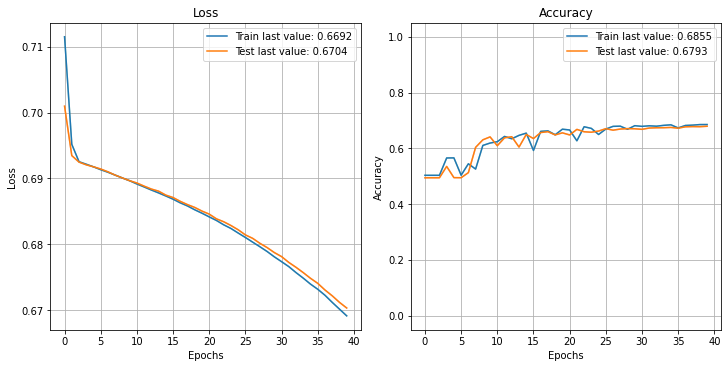

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

# Model 2: Neural averaging network using embedding layer

Now instead of one-hot vectors, we want to use embedding. We change our first layer in model1 to an Embedding layer. This layer takes the integer-encoded vocabulary and looks up the embedding vector for each word-index. These vectors are learned as the model trains. The vectors add a dimension to the output array. The resulting dimensions are: (batch, sequence, embedding).

In [ ]:
VOCAB_SIZE

10000

In [ ]:
EMBED_SIZE=100
target_word = Input((256,), dtype='int32')
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=256)(target_word)
#target_input = Reshape((EMBED_SIZE, ))(target_embedding)

In [ ]:
target_embedding.shape

TensorShape([None, 256, 100])

In [ ]:
# your code goes here
import tensorflow as tf
from keras.models import Model
#model_one_hot=OneHot(VOCAB_SIZE,MAX_SEQUENCE_LENGTH)(target_word)
model_second=GlobalAveragePooling1DMasked()(target_embedding)
output_layer = Dense(16,activation = 'sigmoid')(model_second)
output_layer_1 = Dense(1,activation = 'sigmoid')(output_layer)
model2 = Model(inputs=[target_word], outputs=output_layer_1)
model2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model2.summary()


Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 256, 100)         1000000   
 ng)                                                             
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked_1 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_2 (Dense)             (None, 16)                1616      
                                                                 
 dense_3 (Dense)             (None, 1)                 17        
                                                           

In [ ]:
history = model2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 1s 14ms/step - loss: 0.6933 - accuracy: 0.5286 - val_loss: 0.6904 - val_accuracy: 0.6165
Epoch 2/40
30/30 [==============================] - 0s 9ms/step - loss: 0.6869 - accuracy: 0.6565 - val_loss: 0.6824 - val_accuracy: 0.6858
Epoch 3/40
30/30 [==============================] - 0s 9ms/step - loss: 0.6733 - accuracy: 0.7273 - val_loss: 0.6644 - val_accuracy: 0.7247
Epoch 4/40
30/30 [==============================] - 0s 9ms/step - loss: 0.6487 - accuracy: 0.7351 - val_loss: 0.6368 - val_accuracy: 0.7435
Epoch 5/40
30/30 [==============================] - 0s 9ms/step - loss: 0.6135 - accuracy: 0.7632 - val_loss: 0.6011 - val_accuracy: 0.7594
Epoch 6/40
30/30 [==============================] - 0s 9ms/step - loss: 0.5706 - accuracy: 0.7837 - val_loss: 0.5586 - val_accuracy: 0.7838
Epoch 7/40
30/30 [==============================] - 0s 9ms/step - loss: 0.5233 - accuracy: 0.8103 - val_loss: 0.5149 - val_accuracy: 0.8068
Epoch 8/40
30/30 [=

In [ ]:
results = model2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.3445 - accuracy: 0.8701


In [ ]:
print (results)

[0.34454700350761414, 0.8700799942016602]


The accuracy of model2 is 87%. Using Embedding layer instead of one-hot layer improved the performance.

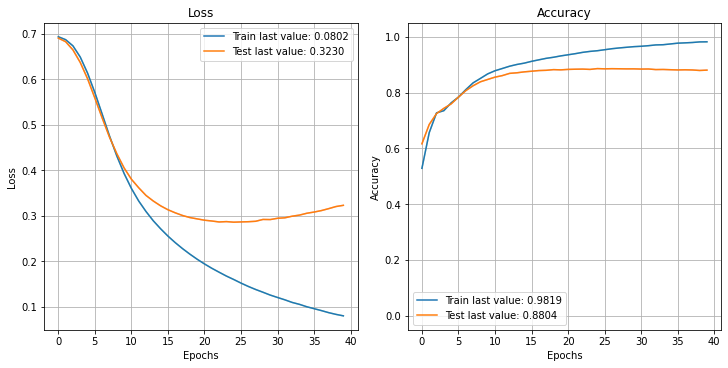

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

# Model 3: Using pre-trained word embeddings

### Preparing pre-trained word embeddings (GLOVE)

The Embedding layer can be used to load a pre-trained word embedding model. We are going to use GloVe embeddings, which you can read about it here (https://nlp.stanford.edu/projects/glove/). GloVe stands for "Global Vectors for Word Representation". It's a somewhat popular embedding technique based on factorizing a matrix of word co-occurence statistics. You can download GloVe and we can seed the Keras Embedding layer with weights from the pre-trained embedding for the words in your dataset.
First, we need to read GloVe and map words to GloVe:


In [ ]:
def readGloveFile(gloveFile):
    with open(gloveFile, 'r') as f:
        wordToGlove = {}  
        wordToIndex = {}  
        indexToWord = {}  

        for line in f:
            record = line.strip().split()
            token = record[0] 
            wordToGlove[token] = np.array(record[1:], dtype=np.float64) 
            
        tokens = sorted(wordToGlove.keys())
        for idx, tok in enumerate(tokens):
            kerasIdx = idx + 1  
            wordToIndex[tok] = kerasIdx 
            indexToWord[kerasIdx] = tok 

    return wordToIndex, indexToWord, wordToGlove

Now, we create our pre-trained Embedding layer:

In [ ]:
from keras.initializers import Constant

def createPretrainedEmbeddingLayer(wordToGlove, wordToIndex, isTrainable):
    vocabLen = len(wordToIndex) + 1  
    embDim = next(iter(wordToGlove.values())).shape[0]  
   
    embeddingMatrix = np.zeros((vocabLen, embDim))  
    for word, index in wordToIndex.items():
        embeddingMatrix[index, :] = wordToGlove[word] 

    embeddingLayer = Embedding(vocabLen, embDim, embeddings_initializer=Constant(embeddingMatrix), trainable=isTrainable, name='GloVe_Embeddings')
    return embeddingLayer

In [ ]:
!wget http://nlp.stanford.edu/data/glove.6B.zip
!unzip '/content/glove.6B.zip'

--2022-03-14 12:01:57--  http://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.6B.zip [following]
--2022-03-14 12:01:57--  https://nlp.stanford.edu/data/glove.6B.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2022-03-14 12:01:57--  http://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6

We freeze the weights. To create the model: 

In [ ]:
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.50d.txt')
# wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.100d.txt')
wordToIndex,indexToWord,wordToGlove=readGloveFile('/content/glove.6B.300d.txt')

# vocabLen = len(wordToIndex) + 1 

EMBED_SIZE = next(iter(wordToGlove.values())).shape[0]
print('Size of Embedding: ',EMBED_SIZE)

embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)

Size of Embedding:  300


## Model 3-1: Neural bag of words using pre-trained word embeddings

Now we change our model to use GloVe:

In [ ]:
# your code goes here
import tensorflow as tf
from keras.models import Model
#model_one_hot=OneHot(VOCAB_SIZE,MAX_SEQUENCE_LENGTH)(target_word)
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=False)(target_word)
model_second=GlobalAveragePooling1DMasked()(embeddingLayer)
output_layer = Dense(16,activation = 'sigmoid')(model_second)
output_layer_1 = Dense(1,activation = 'sigmoid')(output_layer)
model3 = Model(inputs=[target_word], outputs=output_layer_1)
model3.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_2 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_4 (Dense)             (None, 16)                4816      
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                           

In [ ]:
# Train and test the model
history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/40
30/30 [==============================] - 1s 12ms/step - loss: 0.6911 - accuracy: 0.5261 - val_loss: 0.6906 - val_accuracy: 0.5060
Epoch 2/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6878 - accuracy: 0.5749 - val_loss: 0.6865 - val_accuracy: 0.5839
Epoch 3/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6846 - accuracy: 0.5883 - val_loss: 0.6837 - val_accuracy: 0.5861
Epoch 4/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6817 - accuracy: 0.5892 - val_loss: 0.6814 - val_accuracy: 0.5883
Epoch 5/40
30/30 [==============================] - 0s 7ms/step - loss: 0.6792 - accuracy: 0.5963 - val_loss: 0.6787 - val_accuracy: 0.5930
Epoch 6/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6770 - accuracy: 0.5927 - val_loss: 0.6764 - val_accuracy: 0.5954
Epoch 7/40
30/30 [==============================] - 0s 6ms/step - loss: 0.6746 - accuracy: 0.6009 - val_loss: 0.6743 - val_accuracy: 0.5966
Epoch 8/40
30/30 [=

In [ ]:
results = model3.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.6073 - accuracy: 0.6798


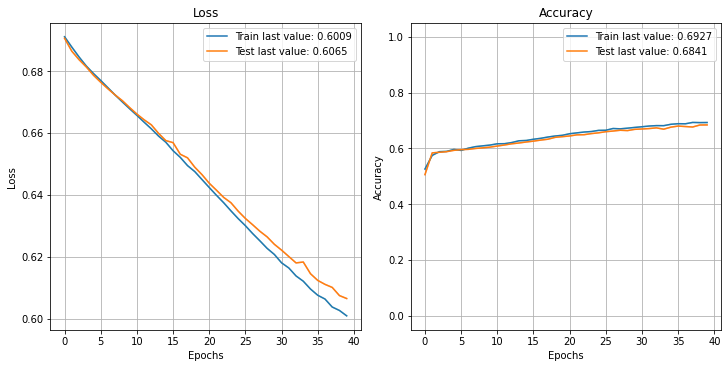

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

To compare freezing and fine-tuning the pre-train embedding weights, we fine-tune the weights here:

In [ ]:
# your code goes here
import tensorflow as tf
from keras.models import Model
#model_one_hot=OneHot(VOCAB_SIZE,MAX_SEQUENCE_LENGTH)(target_word)
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)(target_word)
model_second=GlobalAveragePooling1DMasked()(embeddingLayer)
output_layer = Dense(16,activation = 'sigmoid')(model_second)
output_layer_1 = Dense(1,activation = 'sigmoid')(output_layer)
model3 = Model(inputs=[target_word], outputs=output_layer_1)
model3.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3.summary()

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_3 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_6 (Dense)             (None, 16)                4816      
                                                                 
 dense_7 (Dense)             (None, 1)                 17        
                                                           

In [ ]:
# Train and test the model
history = model3.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 46ms/step - loss: 0.6907 - accuracy: 0.5244 - val_loss: 0.6863 - val_accuracy: 0.6120
Epoch 2/40
30/30 [==============================] - 1s 40ms/step - loss: 0.6807 - accuracy: 0.6246 - val_loss: 0.6755 - val_accuracy: 0.6319
Epoch 3/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6648 - accuracy: 0.6572 - val_loss: 0.6550 - val_accuracy: 0.6652
Epoch 4/40
30/30 [==============================] - 1s 40ms/step - loss: 0.6376 - accuracy: 0.6934 - val_loss: 0.6238 - val_accuracy: 0.7020
Epoch 5/40
30/30 [==============================] - 1s 40ms/step - loss: 0.5977 - accuracy: 0.7327 - val_loss: 0.5814 - val_accuracy: 0.7448
Epoch 6/40
30/30 [==============================] - 1s 40ms/step - loss: 0.5469 - accuracy: 0.7723 - val_loss: 0.5305 - val_accuracy: 0.7801
Epoch 7/40
30/30 [==============================] - 1s 44ms/step - loss: 0.4908 - accuracy: 0.8114 - val_loss: 0.4789 - val_accuracy: 0.8133
Epoch 8/40
30

In [ ]:
# Train and test the model
results = model3.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.3830 - accuracy: 0.8650


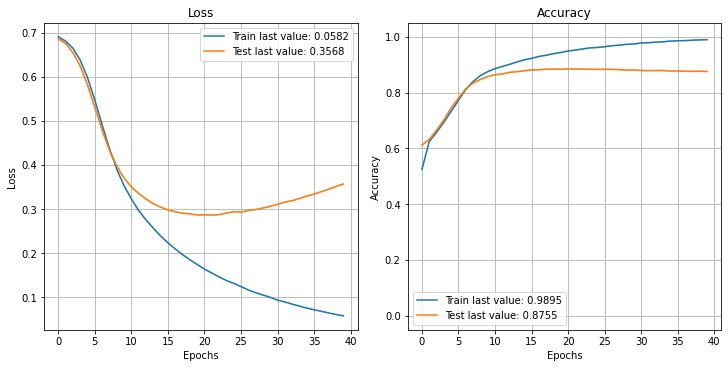

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

Experiments here show that fine-tuning the pre-trained embeddings would obtain better accuracy.

Note that although fine-tuning the pre-trained embeddings is better here, we do not fine-tune it in other models. You could conduct extra experiments to compare the results.

##  Model 3-2: LSTM with pre-trained word embeddings

In previous labs, we have conducted an experiment based on LSTM. Now, we replace its embeddings with the GloVe pre-trained embeddings.

In [ ]:
LSTM_layer=LSTM(units=100,activation='tanh',return_sequences=False)(embeddingLayer)
output_layer = Dense(1,activation = 'relu')(LSTM_layer)
model7 = Model(inputs=[target_word], outputs=output_layer)
model7.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])

In [ ]:
model7.summary()

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 100)               160400    
                                                                 
 dense_8 (Dense)             (None, 1)                 101       
                                                                 
Total params: 120,160,801
Trainable params: 120,160,801
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train and test the model
history = model7.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)


Epoch 1/40
30/30 [==============================] - 8s 111ms/step - loss: 1.3544 - accuracy: 0.5547 - val_loss: 1.5730 - val_accuracy: 0.5325
Epoch 2/40
30/30 [==============================] - 3s 93ms/step - loss: 1.1972 - accuracy: 0.5582 - val_loss: 0.9356 - val_accuracy: 0.5610
Epoch 3/40
30/30 [==============================] - 3s 92ms/step - loss: 1.3333 - accuracy: 0.5489 - val_loss: 1.2767 - val_accuracy: 0.5565
Epoch 4/40
30/30 [==============================] - 3s 92ms/step - loss: 1.0146 - accuracy: 0.5693 - val_loss: 0.8938 - val_accuracy: 0.5720
Epoch 5/40
30/30 [==============================] - 3s 92ms/step - loss: 1.0635 - accuracy: 0.5543 - val_loss: 1.2036 - val_accuracy: 0.5163
Epoch 6/40
30/30 [==============================] - 3s 92ms/step - loss: 0.8113 - accuracy: 0.5442 - val_loss: 0.7040 - val_accuracy: 0.5282
Epoch 7/40
30/30 [==============================] - 3s 92ms/step - loss: 0.6725 - accuracy: 0.5671 - val_loss: 0.6811 - val_accuracy: 0.5552
Epoch 8/40
3

In [ ]:
results = model7.evaluate(X_test_enc, y_test)

782/782 [==============================] - 6s 8ms/step - loss: 0.6153 - accuracy: 0.7982


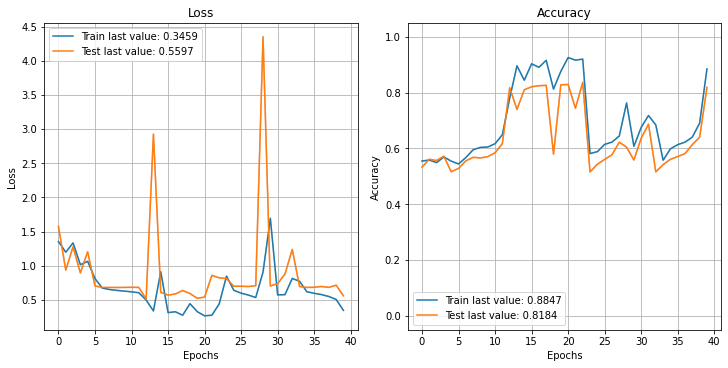

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

Experiment show that simply replacing the lab 2 model embeddings with pre-trained word embeddings (GloVe) will cause performance to drop significantly. 
What can you do to improve the situation?

#  Model 4: Adding extra dense layer into Neural averaging network model

We add extra dense layers into model 3-1 (neural network model) to evaluate extra dense layers' contribution. We start by adding one layer, then add two. All parameters are the same as model 3-1.

### Adding one extra dense layer

In [ ]:
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)(target_word)
model_second=GlobalAveragePooling1DMasked()(embeddingLayer)
output_layer_first = Dense(100,activation = 'sigmoid')(model_second)
output_layer = Dense(16,activation = 'sigmoid')(output_layer_first)
output_layer_1 = Dense(1,activation = 'sigmoid')(output_layer)
model3_dense = Model(inputs=[target_word], outputs=output_layer_1)
model3_dense.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3_dense.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_4 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_9 (Dense)             (None, 100)               30100     
                                                                 
 dense_10 (Dense)            (None, 16)                1616      
                                                           

In [ ]:
history = model3_dense.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 46ms/step - loss: 0.7213 - accuracy: 0.4984 - val_loss: 0.6942 - val_accuracy: 0.4986
Epoch 2/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6924 - accuracy: 0.5167 - val_loss: 0.6895 - val_accuracy: 0.5370
Epoch 3/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6868 - accuracy: 0.5759 - val_loss: 0.6833 - val_accuracy: 0.6128
Epoch 4/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6770 - accuracy: 0.6454 - val_loss: 0.6704 - val_accuracy: 0.6666
Epoch 5/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6572 - accuracy: 0.6857 - val_loss: 0.6447 - val_accuracy: 0.6891
Epoch 6/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6188 - accuracy: 0.7177 - val_loss: 0.5973 - val_accuracy: 0.7271
Epoch 7/40
30/30 [==============================] - 1s 40ms/step - loss: 0.5561 - accuracy: 0.7597 - val_loss: 0.5290 - val_accuracy: 0.7761
Epoch 8/40
30

In [ ]:
results = model3_dense.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 0.4949 - accuracy: 0.8578


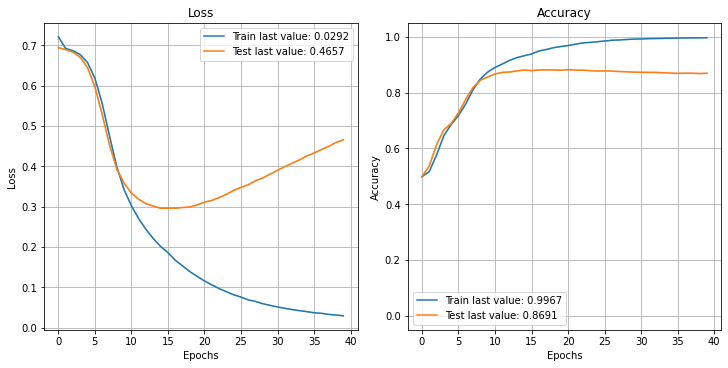

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

### Adding two extra dense layers

In [ ]:
embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)(target_word)
model_second=GlobalAveragePooling1DMasked()(embeddingLayer)
output_layer_zero = Dense(300,activation = 'relu')(model_second)
output_layer_first = Dense(100,activation = 'relu')(output_layer_zero)
output_layer = Dense(16,activation = 'relu')(output_layer_first)
output_layer_1 = Dense(1,activation = 'sigmoid')(output_layer)
model3_dense_2 = Model(inputs=[target_word], outputs=output_layer_1)
model3_dense_2.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model3_dense_2.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256)]             0         
                                                                 
 GloVe_Embeddings (Embedding  (None, 256, 300)         120000300 
 )                                                               
                                                                 
 global_average_pooling1d_ma  (None, 300)              0         
 sked_5 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_12 (Dense)            (None, 300)               90300     
                                                                 
 dense_13 (Dense)            (None, 100)               30100     
                                                           

In [ ]:
history = model3_dense_2.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 2s 46ms/step - loss: 0.6848 - accuracy: 0.5632 - val_loss: 0.6688 - val_accuracy: 0.6059
Epoch 2/40
30/30 [==============================] - 1s 41ms/step - loss: 0.6293 - accuracy: 0.6571 - val_loss: 0.5680 - val_accuracy: 0.7309
Epoch 3/40
30/30 [==============================] - 1s 41ms/step - loss: 0.4643 - accuracy: 0.7967 - val_loss: 0.4031 - val_accuracy: 0.8227
Epoch 4/40
30/30 [==============================] - 1s 41ms/step - loss: 0.3297 - accuracy: 0.8605 - val_loss: 0.3354 - val_accuracy: 0.8632
Epoch 5/40
30/30 [==============================] - 1s 41ms/step - loss: 0.2543 - accuracy: 0.8983 - val_loss: 0.3116 - val_accuracy: 0.8732
Epoch 6/40
30/30 [==============================] - 1s 40ms/step - loss: 0.2144 - accuracy: 0.9157 - val_loss: 0.3081 - val_accuracy: 0.8799
Epoch 7/40
30/30 [==============================] - 1s 40ms/step - loss: 0.1715 - accuracy: 0.9369 - val_loss: 0.3125 - val_accuracy: 0.8796
Epoch 8/40
30

In [ ]:
results = model3_dense_2.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 1.1788 - accuracy: 0.8438


These two experiments show that adding extra dense layers can slightly improve accuracy over model 3-1.

---



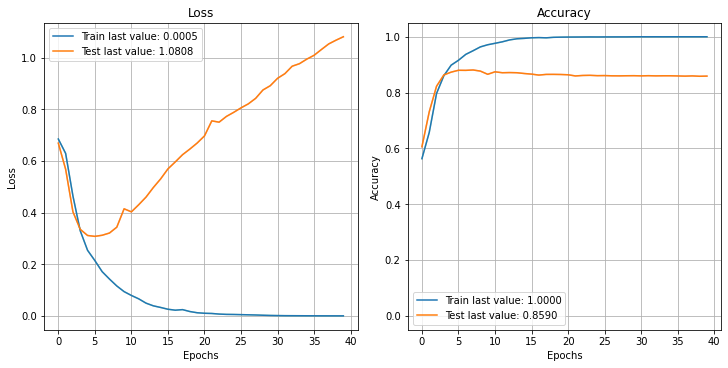

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

#  Model 5: CNN for Text Classification

In this section, we build a Convolutional Neural Network (CNN) for text classification. We start by using one CNN layer and then adding another layer. You could use embeddings from pre-trained or scratch.

##  Model 5-1: Basic CNN model for Text Classification 

In [ ]:
target_word = Input((256,), dtype='int32')
target_embedding = Embedding(VOCAB_SIZE, EMBED_SIZE, name='target_embed_layer',
                        	embeddings_initializer='glorot_uniform',
                         	input_length=256)(target_word)

In [ ]:
#embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)(target_word)
#model_second=GlobalAveragePooling1DMasked()(target_embedding)
from keras.layers.convolutional import Conv1D   
#embeddingLayer=createPretrainedEmbeddingLayer(wordToGlove,wordToIndex,isTrainable=True)(target_word)
conv_layer=Conv1D(100,6)(target_embedding)
model_second=GlobalAveragePooling1DMasked()(conv_layer)
# output_layer_zero = Dense(300,activation = 'sigmoid')(conv_layer)
# output_layer_first = Dense(100,activation = 'sigmoid')(output_layer_zero)
# output_layer = Dense(16,activation = 'sigmoid')(output_layer_first)
output_layer_1 = Dense(1,activation = 'sigmoid')(model_second)
model4 = Model(inputs=[target_word], outputs=output_layer_1)
model4.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model4.summary()

Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 256, 300)         3000000   
 ng)                                                             
                                                                 
 conv1d (Conv1D)             (None, 251, 100)          180100    
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked_6 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                                 
 dense_16 (Dense)            (None, 1)                 101       
                                                           

In [ ]:
# Train and test the model

# your code goes here
history = model4.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 8s 47ms/step - loss: 0.6347 - accuracy: 0.6497 - val_loss: 0.5041 - val_accuracy: 0.7763
Epoch 2/40
30/30 [==============================] - 1s 40ms/step - loss: 0.3645 - accuracy: 0.8545 - val_loss: 0.3320 - val_accuracy: 0.8600
Epoch 3/40
30/30 [==============================] - 1s 40ms/step - loss: 0.2325 - accuracy: 0.9090 - val_loss: 0.2983 - val_accuracy: 0.8797
Epoch 4/40
30/30 [==============================] - 1s 39ms/step - loss: 0.1624 - accuracy: 0.9441 - val_loss: 0.3070 - val_accuracy: 0.8816
Epoch 5/40
30/30 [==============================] - 1s 39ms/step - loss: 0.1183 - accuracy: 0.9613 - val_loss: 0.3497 - val_accuracy: 0.8730
Epoch 6/40
30/30 [==============================] - 1s 40ms/step - loss: 0.0864 - accuracy: 0.9748 - val_loss: 0.3832 - val_accuracy: 0.8751
Epoch 7/40
30/30 [==============================] - 1s 40ms/step - loss: 0.0622 - accuracy: 0.9833 - val_loss: 0.4468 - val_accuracy: 0.8653
Epoch 8/40
30

In [ ]:
results = model4.evaluate(X_test_enc, y_test)

782/782 [==============================] - 2s 3ms/step - loss: 1.3514 - accuracy: 0.8404


In [ ]:
pip install plot_keras_history

In [ ]:
from plot_keras_history import plot_history
import matplotlib.pyplot as plt


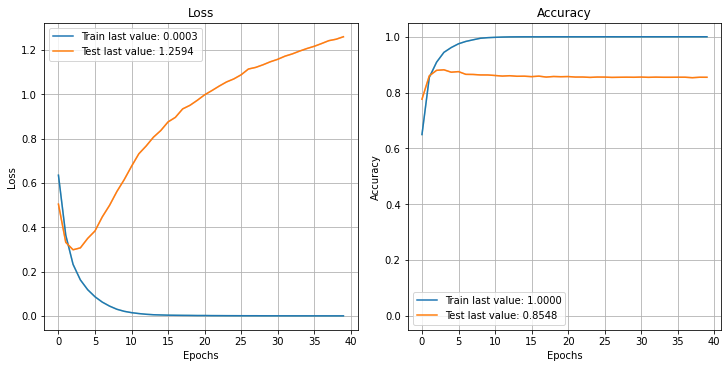

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

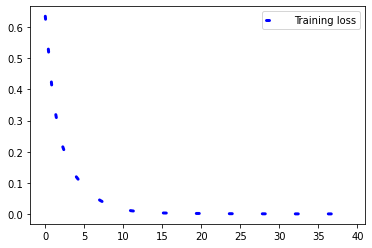

In [ ]:
plt.plot(history.history['loss'],color='blue', linewidth=3,linestyle=(0, (1, 10)),markersize=10,dash_capstyle='round')
plt.legend(['Training loss']);

## Model 5-2: Adding extra convolutional layer

In [ ]:
conv_layer=Conv1D(100,6)(target_embedding)
conv_layer_2=Conv1D(100,6)(conv_layer)
model_second=GlobalAveragePooling1DMasked()(conv_layer_2)
output_layer_1 = Dense(1,activation = 'sigmoid')(model_second)
model6 = Model(inputs=[target_word], outputs=output_layer_1)
model6.compile(loss='binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model6.summary()

Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 256)]             0         
                                                                 
 target_embed_layer (Embeddi  (None, 256, 300)         3000000   
 ng)                                                             
                                                                 
 conv1d_1 (Conv1D)           (None, 251, 100)          180100    
                                                                 
 conv1d_2 (Conv1D)           (None, 246, 100)          60100     
                                                                 
 global_average_pooling1d_ma  (None, 100)              0         
 sked_7 (GlobalAveragePoolin                                     
 g1DMasked)                                                      
                                                           

In [ ]:
# Train and test the model

history = model6.fit(partial_X_train,
                    partial_y_train,
                    epochs=40,
                    batch_size=512,
                    validation_data=(X_val, y_val),
                    verbose=1)

Epoch 1/40
30/30 [==============================] - 3s 58ms/step - loss: 0.1757 - accuracy: 0.9702 - val_loss: 0.9150 - val_accuracy: 0.8612
Epoch 2/40
30/30 [==============================] - 2s 51ms/step - loss: 0.0046 - accuracy: 0.9989 - val_loss: 1.2882 - val_accuracy: 0.8546
Epoch 3/40
30/30 [==============================] - 2s 52ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 1.3929 - val_accuracy: 0.8540
Epoch 4/40
30/30 [==============================] - 2s 52ms/step - loss: 5.2449e-04 - accuracy: 1.0000 - val_loss: 1.4663 - val_accuracy: 0.8546
Epoch 5/40
30/30 [==============================] - 2s 51ms/step - loss: 2.6333e-04 - accuracy: 1.0000 - val_loss: 1.5114 - val_accuracy: 0.8544
Epoch 6/40
30/30 [==============================] - 2s 51ms/step - loss: 2.2116e-04 - accuracy: 1.0000 - val_loss: 1.5492 - val_accuracy: 0.8530
Epoch 7/40
30/30 [==============================] - 2s 52ms/step - loss: 2.2202e-04 - accuracy: 1.0000 - val_loss: 1.5871 - val_accuracy: 0.85

In [ ]:
results = model6.evaluate(X_test_enc, y_test)

782/782 [==============================] - 3s 3ms/step - loss: 2.2815 - accuracy: 0.8379


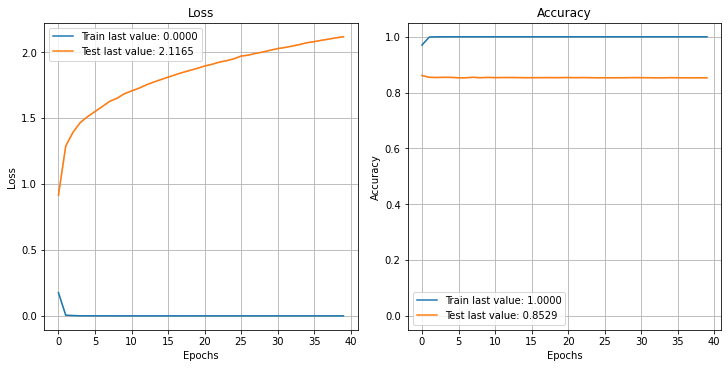

In [ ]:
plot_history(history.history, path="standard.png")
plt.show()

Although adding layer here reduces the training loss, the evaluation accuracy is worse than the model without the extra convolutional layer.

Adding more layers can help you to extract more features. But we can do that up to a certain extent. After some point, instead of extracting features, we tend to overfit the data. Overfitting can lead to errors in on form or another, such as false positives. It is not easy to choose the number of units in a hidden layer or the number of hidden layers in a neural network. For many applications, one hidden layer is enough. As a general rule, the number of units in that hidden layer is between the number of inputs and the number of outputs.
 The best way to decide on the number of units and hidden layers is to try various parameters. Train several neural networks with different numbers of hidden layers and neurons, and monitor the performance of them. You will have to experiment using a series of different architectures. 







---

